In [70]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from simpledbf import Dbf5

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import operator 
from ReclassifyLandUse import ReC

import importlib
import DamageEstimation
importlib.reload( DamageEstimation )
from DamageEstimation import DepthDamage

import pickle
from pyogrio import read_dataframe, write_dataframe
from geo_northarrow import add_north_arrow
from  NFIP_calculator import Insurer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.pylab import cm
from matplotlib.colors import rgb2hex


import warnings
import seaborn as sns
import scipy.stats as stats
import pydeck as pdk

warnings.filterwarnings('ignore')


In [10]:
fp = "../inputs/gis_data/Parcel_input_sce1.shp"
Geodata = read_dataframe(fp)
#Geodata['TARGET_FID'] = Geodata['index']
Geodata                = Geodata.to_crs({'init':'epsg:4326'})
print( Geodata.columns )

Index(['index', 'TARGET_FID', 'VAL19TOT', 'VAL19LAND', 'VAL19IMP', 'LANDUSE',
       'landCode', 'LUCode', 'poicode', 'poiclass', 'poiname', 'watercode',
       'waterclass', 'watername', 'parkigcode', 'parkigclas', 'LUCode01re',
       'LUCode06re', 'LUCode11re', 'LUCode15re', 'LUCode20re', 'ZipCode',
       'policyCost', 'policyCoun', 'elevationN', 'Content_Bu', 'ACRES',
       'Cate1', 'Cate2', 'Cate3', 'Cate4', 'Cate5', 'NumStories', 'Foundation',
       'FirstFloor', 'ContentCos', 'BldgDamage', 'CDDF_ID', 'YEARBUILT',
       'Tract', 'Insurance', 'PopTot', 'TotalUnit', 'Mobile', 'vacant',
       'MedHHInc', 'TotAge65', 'BelowHigh', 'BelPoverty', 'Minority',
       'PopWhite', 'DEM', 'BeachDist', 'HealthDist', 'ParkDist', 'SchoolDist',
       'CoastDist', 'WetlatDist', 'floodzones', 'buildDEM', 'H_ft', 'PArea',
       'slope_mhw', 'logAccess', 'area_2', 'pararea', 'Risk', 'NN1', 'NN2',
       'NN3', 'NN4', 'NN5', 'NEAR_DIST', 'NEA_DIST2', 'WaterCoast',
       'predprobs', 'predLU',

In [3]:
Geodata['VAL19IMP']= Geodata['VAL19IMP'].fillna(0)
#Geodata['ImpValCat'].unique()
#len(cmap)
print( Geodata['VAL19IMP'].quantile( [0.25, 0.5, 0.75, 1 ]) )

0.25            0.0
0.50       110040.0
0.75       204670.0
1.00    267928450.0
Name: VAL19IMP, dtype: float64


['0 - 100', '200 - 300', '0 - 0', 'Above 300', '100 - 200']
Categories (5, object): ['0 - 0' < '0 - 100' < '100 - 200' < '200 - 300' < 'Above 300']
0 - 0
0 - 100
100 - 200
200 - 300
Above 300


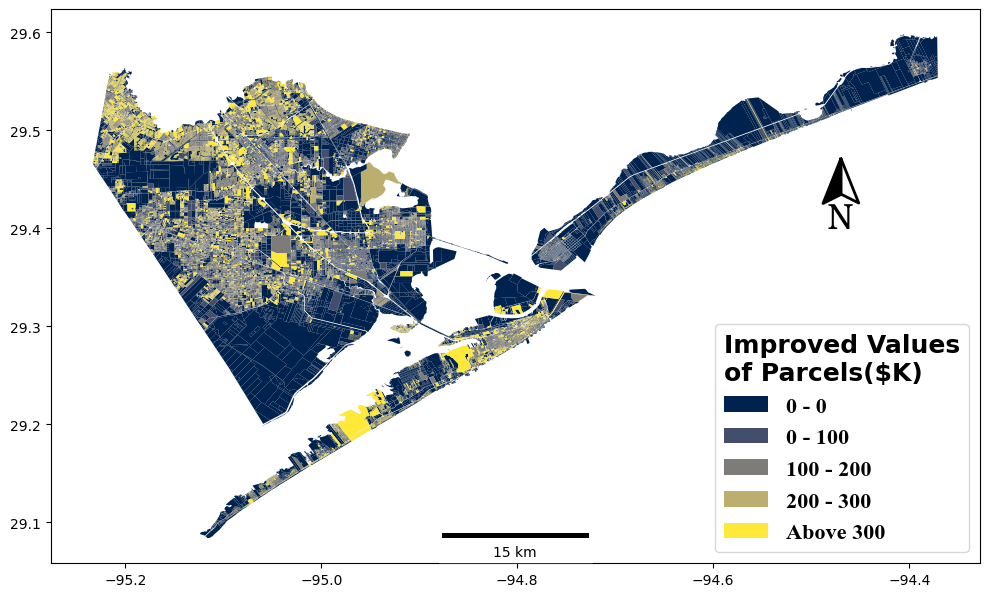

In [4]:
cmap = cm.get_cmap('cividis', 5)
#Geodata[ 'risk_20' ] = Geodata[ 'Risk' ] *  Geodata[ 'VAL19IMP' ]
#Geodata['VAL19TOT'] = Geodata['VAL19TOT'].astype(float)
Geodata['VAL19IMP'] = Geodata['VAL19IMP'].astype(float)
bins = [Geodata['VAL19IMP'].min()-1, 0, 1.0e5, 2e5, 3e5, Geodata['VAL19IMP'].max() + 1]  # Adjust these values based on your data range
Geodata['ImpValCat'] = pd.cut( Geodata['VAL19IMP'], bins, 
                               labels=['0 - 0', '0 - 100',  '100 - 200',  '200 - 300', 
                                       'Above 300'] )
#VAL19IMP, Geodata['VAL19TOT']
#cmap = cm.get_cmap('bwr', 4)
#rgb2hex(cmap(1))
#color_map = {'0 - 100': 'lightgrey', '100 - 150': 'Violet', 
#             '150 - 250': 'Orchid', 
#             'Above 250': 'Fuchsia' }

color_map = { '0 - 0'  : rgb2hex(cmap(0)),   '0 - 100': rgb2hex(cmap(1)), 
              '100 - 200': rgb2hex(cmap(2)), '200 - 300': rgb2hex(cmap(3)),
              'Above 300': rgb2hex(cmap(4))  }
Geodata['ImpValColor'] = Geodata['ImpValCat'].map(color_map)

print( Geodata['ImpValCat'].unique() )
fig, ax = plt.subplots( figsize=(10, 8)  )
pmarks = []
for category, color in color_map.items():
        labeli = category
        print(category)
        Geodata[ Geodata['ImpValCat'] == category ].plot( column='ImpValCat', 
            #scheme="Quantiles", k = 5,
            color = color, edgecolor = 'black',
            linewidth = 0.01, aspect=1,
            ax = ax )
        pmarks.append(Patch(facecolor=color, label=labeli))

#ax.legend(title='Building improvement\nvalue (Thousand$)')

handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="Improved Values\nof Parcels($K)",
            title_fontsize= 'xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon= True )

legend = ax.get_legend()
legend.set_title( "Improved Values\nof Parcels($K)" , prop={'size' : 18, 'weight':'bold'})
leg._legend_box.align = "left"
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist( ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
plt.tight_layout()
#plt.savefig('../output_images/Risk_test0.png',dpi=900, bbox_inches='tight', pad_inches=0)

plt.show()


In [61]:
#from pydeck_earthengine_layers import EarthEngineLayer
#import pydeck as pdk
import plotly.express as px
import geopandas as gpd

mapbox_access_token = ""


In [62]:
fp = "../inputs/gis_data/footprints_processed/building_galv_sce.shp"
#gdf = gpd.read_file(fp)
gdf = read_dataframe(fp)
#Geodata['TARGET_FID'] = Geodata['index']
#Geodata                = Geodata.to_crs({'init':'epsg:4326'})
#geojson = gdf.__geo_interface__


In [63]:
print( gdf.head() )

   Join_Count  TARGET_FID  release             capture_da     area   index  \
0           1           0        2  11/19/2019-11/24/2019  158.423  170046   
1           1           1        2  11/19/2019-11/24/2019  167.151   82248   
2           1           2        2  11/19/2019-11/24/2019   65.293  129978   
3           1           3        2  11/19/2019-11/24/2019  136.991       1   
4           1           4        2  11/19/2019-11/24/2019  360.395       2   

   OBJECTID               GEOID      ID                       NAME  ...  \
0    207428  0182-0023-0003-000  312853   MACK HAROLD R & LOREATHY  ...   
1    208136  0055-0062-0000-000  174032               LOPEZ RITA M  ...   
2    207311  0182-0023-0004-000  312854  MACK NAPOLEON J & CLARA G  ...   
3    207425  0182-0030-0000-000  307794             CITY-HITCHCOCK  ...   
4    235655  5646-0000-0001-000  720713  SANTIAGO ESTEBAN & AWILDA  ...   

   logAccess release_1             capture__1   area_2  pararea   FID_1  \
0   9

In [64]:
print(gdf.shape)

(149140, 135)


In [65]:

def extract_polygon_coords(polygon):
    """
    Extracts x, y coordinates from a polygon geometry.
    """
    if polygon.type == 'Polygon':
        exterior = polygon.exterior
        #print(  polygon )
        return list(exterior.coords)
    elif polygon.type == 'MultiPolygon':
        # In case of MultiPolygon, take the largest polygon
        #print(  polygon )
        all_coords = []
        for part in polygon.geoms:
            all_coords.extend(list(part.exterior.coords))
        return all_coords

# Example: Assuming 'height' column contains the height of each polygon
#gdf['coords'] = gdf['geometry'].apply(extract_polygon_coords)
gdf['height'] = gdf['H_ft']  # Replace 'height_column' with the name of your column


In [66]:
write_dataframe(gdf, "../inputs/gis_data/footprints_processed/galv_footprints.json", driver="GeoJSON")

In [68]:

gdf_footprints = read_dataframe("../inputs/gis_data/footprints_processed/galv_footprints.json")


In [ ]:
gdf_footprints.fillna(0, inplace=True)
gdf_footprints.columns

gdf_footprints['ImpValCat'] = pd.cut( gdf_footprints['VAL19IMP'], bins, 
                               labels=['0 - 0', '0 - 100',  '100 - 200',  '200 - 300', 
                                       'Above 300'] )
gdf_footprints['ImpValNORM'] = gdf_footprints['VAL19IMP'].apply(
    lambda x: (255+((x - gdf_footprints['VAL19IMP'].min())*(255)) )
            / (gdf_footprints['VAL19IMP'].max() - gdf_footprints['VAL19IMP'].min()) )

In [75]:
INITIAL_VIEW_STATE = pdk.ViewState(latitude=41.76375, 
                                   longitude=-72.69102, 
                                   zoom=9, max_zoom=16, pitch=60, bearing=0)

tracts = pdk.Layer(
    "GeoJsonLayer",
    gdf_footprints,
    opacity=1,
    stroked=True,
    filled=True,
    extruded=True,
    wireframe=True,
    pickable=True,
    get_elevation="ImpValCat", # Converting to POPDEN population density per sq m to per sq mile
    #get_fill_color="POPULATION==0?[0,0,0,0]:[ImpValCatNORM+95, ImpValCatNORM+95, ImpValCatNORM+95]",
    #get_line_color="POPULATION==0?[0,0,0,0]:[ImpValCatNORM+50, ImpValCatNORM+50, ImpValCatNORM+50]",
)

# All together
# You can customize by adding more layers if you wish
r = pdk.Deck(layers=[tracts], initial_view_state=INITIAL_VIEW_STATE)

# Exporting as an html file
r.to_html("filename.html")